# Crop Yield Prediction Model - Strategy Notebook

This notebook implements the strategy for building a historical crop yield prediction model:
1. **Get the data right** — Load, clean, harmonize
2. **Basic EDA** — Understand data structure and quality
3. **Department mismatch check** — Verify yield and climate data alignment
4. **Climate missing values & semantics** — Types of missingness, what scenarios/metrics mean, cleaning implications
5. **Yield missing values** — Patterns, recoverability, cleaning implications
6. **Feature engineering** — Merge yield + climate; aggregate climate (mean, max per metric)
7. **Analytical EDA** — Yield trends, climate–yield relationships, seasonal patterns, multicollinearity, geographic structure

## 1. Load the data

In [1]:
import pandas as pd
import numpy as np

YIELD_PATH = "../raw_data/barley_yield_from_1982.csv"
CLIMATE_PATH = "../raw_data/climate_data_from_1982.parquet"

# Load yield data (CSV is semicolon-separated)
df_yield = pd.read_csv(YIELD_PATH, sep=";")

# Load climate data
df_climate = pd.read_parquet(CLIMATE_PATH)

print("Yield data:", df_yield.shape)
print("Climate data:", df_climate.shape)

Yield data: (3583, 6)
Climate data: (13540116, 7)


In [2]:
def clean_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Clean column names: lowercase, underscores, alphanumeric only."""
    df = df.copy()
    df.columns = (
        df.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^a-z0-9_]", "", regex=True)
    )
    return df

df_yield = clean_cols(df_yield)
df_climate = clean_cols(df_climate)

# Harmonize department column name (yield has 'department', climate has 'nom_dep')
df_yield = df_yield.rename(columns={"department": "nom_dep"})

# Ensure numeric types
df_yield["year"] = pd.to_numeric(df_yield["year"], errors="coerce")
df_yield["yield"] = pd.to_numeric(df_yield["yield"], errors="coerce")

print("Yield columns:", df_yield.columns.tolist())
print("Climate columns:", df_climate.columns.tolist())

Yield columns: ['unnamed_0', 'nom_dep', 'year', 'yield', 'area', 'production']
Climate columns: ['scenario', 'nom_dep', 'code_dep', 'time', 'year', 'metric', 'value']


## 2. Basic EDA

In [3]:
print("=" * 60)
print("YIELD DATA")
print("=" * 60)
print("Shape:", df_yield.shape)
print("\nFirst rows:")
display(df_yield.head(10))
print("\nDtypes:")
print(df_yield.dtypes)
print("\nMissing values (%):")
print((df_yield.isna().mean() * 100).round(2))
print("\nNumeric stats:")
display(df_yield.describe())

YIELD DATA
Shape: (3583, 6)

First rows:


,unnamed_0,nom_dep,year,yield,area,production
0,82,Ain,1982,3.95008,16065.0,63458.0
1,83,Ain,1983,NaN,14500.0,38400.0
2,84,Ain,1984,4.82258,15500.0,74750.0
3,85,Ain,1985,4.19677,15500.0,65050.0
4,86,Ain,1986,3.59845,12900.0,46420.0
5,87,Ain,1987,4.92000,15000.0,73800.0
6,88,Ain,1988,3.98092,13100.0,52150.0
7,89,Ain,1989,5.03846,13000.0,65500.0
8,90,Ain,1990,4.64400,12500.0,58050.0
9,91,Ain,1991,5.06772,12700.0,64360.0



Dtypes:
unnamed_0       int64
nom_dep        object
year            int64
yield         float64
area          float64
production    float64
dtype: object

Missing values (%):
unnamed_0     0.00
nom_dep       0.00
year          0.00
yield         6.89
area          3.21
production    3.40
dtype: float64

Numeric stats:


,unnamed_0,year,yield,area,production
count,3583.000000,3583.000000,3336.000000,3468.000000,3461.000000
mean,5805.017862,1999.971532,5.212239,18767.079585,110239.297180
std,3330.517723,10.664744,1.369354,20266.789390,133060.332166
min,82.000000,1982.000000,0.813560,0.000000,0.000000
25%,2945.500000,1991.000000,4.242530,3766.500000,17240.000000
50%,5809.000000,2000.000000,5.261230,11810.500000,56744.900000
75%,8672.500000,2009.000000,6.225615,27495.500000,153285.200000
max,11536.000000,2018.000000,8.400000,119310.000000,919249.600000


In [4]:
print("=" * 60)
print("CLIMATE DATA")
print("=" * 60)
print("Shape:", df_climate.shape)
print("\nFirst rows:")
display(df_climate.head(10))
print("\nDtypes:")
print(df_climate.dtypes)
print("\nMissing values (%):")
print((df_climate.isna().mean() * 100).round(2))
print("\nUnique scenarios:", df_climate["scenario"].unique().tolist())
print("Unique metrics:", df_climate["metric"].unique().tolist())
print("\nTime range:", df_climate["time"].min(), "to", df_climate["time"].max())

CLIMATE DATA
Shape: (13540116, 7)

First rows:


,scenario,nom_dep,code_dep,time,year,metric,value
29950,historical,Ain,01,1982-01-01 12:00:00,1982,near_surface_air_temperature,276.292267
29951,historical,Ain,01,1982-01-02 12:00:00,1982,near_surface_air_temperature,275.092407
29952,historical,Ain,01,1982-01-03 12:00:00,1982,near_surface_air_temperature,276.418518
29953,historical,Ain,01,1982-01-04 12:00:00,1982,near_surface_air_temperature,278.893372
29954,historical,Ain,01,1982-01-05 12:00:00,1982,near_surface_air_temperature,278.887207
29955,historical,Ain,01,1982-01-06 12:00:00,1982,near_surface_air_temperature,277.304535
29956,historical,Ain,01,1982-01-07 12:00:00,1982,near_surface_air_temperature,278.184235
29957,historical,Ain,01,1982-01-08 12:00:00,1982,near_surface_air_temperature,278.639221
29958,historical,Ain,01,1982-01-09 12:00:00,1982,near_surface_air_temperature,279.407043
29959,historical,Ain,01,1982-01-10 12:00:00,1982,near_surface_air_temperature,281.282776



Dtypes:
scenario            object
nom_dep             object
code_dep            object
time        datetime64[ns]
year                 int32
metric              object
value              float32
dtype: object

Missing values (%):
scenario    0.0
nom_dep     0.0
code_dep    0.0
time        0.0
year        0.0
metric      0.0
value       0.0
dtype: float64

Unique scenarios: ['historical', 'ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']
Unique metrics: ['near_surface_air_temperature', 'daily_maximum_near_surface_air_temperature', 'precipitation']

Time range: 1982-01-01 12:00:00 to 2050-12-31 12:00:00


In [5]:
# Year coverage
print("Yield year range:", df_yield["year"].min(), "-", df_yield["year"].max())
print("Climate year range:", df_climate["year"].min(), "-", df_climate["year"].max())
print("\nYield rows with missing yield:", df_yield["yield"].isna().sum(), f"({df_yield['yield'].isna().mean()*100:.1f}%)")

Yield year range: 1982 - 2018
Climate year range: 1982 - 2050

Yield rows with missing yield: 247 (6.9%)


## 3. Department mismatch check

In [6]:
# Get unique departments from each dataset
# For climate: use historical scenario only (what we'll use for training)
clim_historical = df_climate[df_climate["scenario"] == "historical"]

depts_yield = set(df_yield["nom_dep"].dropna().str.strip().unique())
depts_climate = set(clim_historical["nom_dep"].dropna().str.strip().unique())

print("Unique departments in YIELD:", len(depts_yield))
print("Unique departments in CLIMATE (historical):", len(depts_climate))
print()

Unique departments in YIELD: 97
Unique departments in CLIMATE (historical): 89



In [7]:
# Departments in yield but NOT in climate (will cause missing climate features when joining)
in_yield_not_climate = sorted(depts_yield - depts_climate)

# Departments in climate but NOT in yield (less critical - we just won't have yield to predict)
in_climate_not_yield = sorted(depts_climate - depts_yield)

# Departments in BOTH (the overlap we can use)
in_both = sorted(depts_yield & depts_climate)

print("DEPARTMENT MISMATCH ANALYSIS")
print("=" * 50)
print(f"\nIn BOTH (can join): {len(in_both)} departments")
print(f"In YIELD only (no climate - will have missing features): {len(in_yield_not_climate)} departments")
print(f"In CLIMATE only (no yield - cannot train): {len(in_climate_not_yield)} departments")
print()

DEPARTMENT MISMATCH ANALYSIS

In BOTH (can join): 89 departments
In YIELD only (no climate - will have missing features): 8 departments
In CLIMATE only (no yield - cannot train): 0 departments



In [8]:
if in_yield_not_climate:
    print("Departments in YIELD but NOT in CLIMATE:")
    print(in_yield_not_climate)
    print("\n--- Impact: yield rows for these departments will have NaN climate features when joined ---")
else:
    print("No departments in yield are missing from climate.\n")

if in_climate_not_yield:
    print("Departments in CLIMATE but NOT in YIELD:")
    print(in_climate_not_yield)
    print("\n--- Impact: we have climate data but no yield to train on for these departments ---")
else:
    print("No departments in climate are missing from yield.")

Departments in YIELD but NOT in CLIMATE:
['Corse_du_Sud', 'Haute_Corse', 'Hauts_de_Seine', 'Paris', 'Seine_Saint_Denis', 'Seine_SeineOise', 'Val_d_Oise', 'Val_de_Marne']

--- Impact: yield rows for these departments will have NaN climate features when joined ---
No departments in climate are missing from yield.


In [9]:
# Check for potential naming differences (e.g. accents, spaces, hyphens)
# Compare sorted lists to spot near-matches
print("Potential naming differences (fuzzy check):")
for dy in in_yield_not_climate:
    for dc in in_climate_not_yield:
        # Check if similar (e.g. one has underscore, other has space)
        if dy.replace("_", " ").lower() == dc.replace("_", " ").lower():
            print(f"  Possible match: yield='{dy}' <-> climate='{dc}'")
        elif dy.lower() in dc.lower() or dc.lower() in dy.lower():
            print(f"  Similar: yield='{dy}' | climate='{dc}'")

Potential naming differences (fuzzy check):


In [10]:
# Summary verdict
print("=" * 50)
print("VERDICT: Is there a department mismatch?")
print("=" * 50)
if in_yield_not_climate or in_climate_not_yield:
    print("YES - There IS a department mismatch.")
    if in_yield_not_climate:
        n_rows_affected = df_yield[df_yield["nom_dep"].str.strip().isin(in_yield_not_climate)].shape[0]
        pct = 100 * n_rows_affected / len(df_yield)
        print(f"  - {len(in_yield_not_climate)} departments in yield have no climate data")
        print(f"  - This affects {n_rows_affected} yield rows ({pct:.1f}%)")
    if in_climate_not_yield:
        print(f"  - {len(in_climate_not_yield)} departments in climate have no yield data")
    print("\nRecommendation: Drop yield rows for departments not in climate, or create a mapping if names differ.")
else:
    print("NO - All departments align. Yield and climate can be joined without mismatch.")

VERDICT: Is there a department mismatch?
YES - There IS a department mismatch.
  - 8 departments in yield have no climate data
  - This affects 290 yield rows (8.1%)

Recommendation: Drop yield rows for departments not in climate, or create a mapping if names differ.


## 4. Climate data: missing values & semantic exploration

We distinguish several types of "missing" or problematic values in the climate data:
1. **Raw missing** — explicit NaN in the data
2. **Coverage missing** — data absent for certain (scenario, year) combinations by design
3. **Data quality issues** — invalid values (e.g. negative precipitation)
4. **Structural missing** — when joining with yield, department mismatch creates NaN

In [11]:
# 1) Raw missing values (explicit NaN)
print("RAW MISSING VALUES")
print("=" * 50)
missing_pct = df_climate.isna().mean() * 100
for col in df_climate.columns:
    print(f"  {col}: {missing_pct[col]:.2f}% missing")
print("\nTotal rows with any NaN:", df_climate.isna().any(axis=1).sum())

RAW MISSING VALUES
  scenario: 0.00% missing
  nom_dep: 0.00% missing
  code_dep: 0.00% missing
  time: 0.00% missing
  year: 0.00% missing
  metric: 0.00% missing
  value: 0.00% missing

Total rows with any NaN: 0


In [12]:
# 2) Coverage missing — year range per scenario (by design)
print("COVERAGE BY SCENARIO (year range)")
print("=" * 50)
for sc in sorted(df_climate["scenario"].unique()):
    sub = df_climate[df_climate["scenario"] == sc]
    y_min, y_max = sub["year"].min(), sub["year"].max()
    n_rows = len(sub)
    print(f"  {sc:15s}: {y_min}-{y_max}  ({n_rows:,} rows)")
print("\n→ historical = past observations (for training)")
print("→ ssp* = future projections (for prediction); no overlap with historical")

COVERAGE BY SCENARIO (year range)
  historical     : 1982-2014  (3,218,151 rows)
  ssp1_2_6       : 2015-2050  (3,510,783 rows)
  ssp2_4_5       : 2015-2050  (3,300,399 rows)
  ssp5_8_5       : 2015-2050  (3,510,783 rows)

→ historical = past observations (for training)
→ ssp* = future projections (for prediction); no overlap with historical


In [13]:
# 3) Data quality issues — invalid values per metric
print("DATA QUALITY BY METRIC")
print("=" * 50)
for m in df_climate["metric"].unique():
    vals = df_climate[df_climate["metric"] == m]["value"]
    n_neg = (vals < 0).sum()
    n_inf = np.isinf(vals).sum()
    print(f"\n  {m}:")
    print(f"    Negative values: {n_neg:,} ({100*n_neg/len(vals):.2f}%)")
    print(f"    Inf values: {n_inf}")
    if n_neg > 0:
        print(f"    Sample negative: {vals[vals < 0].head(3).tolist()}")
print("\n→ Precipitation: negative values are numerical noise (~1e-25); clip to 0 when aggregating.")

DATA QUALITY BY METRIC

  near_surface_air_temperature:
    Negative values: 0 (0.00%)
    Inf values: 0

  daily_maximum_near_surface_air_temperature:
    Negative values: 0 (0.00%)
    Inf values: 0

  precipitation:
    Negative values: 182,620 (4.08%)
    Inf values: 0
    Sample negative: [-2.3102508979783016e-25, -3.2729552995541637e-25, -5.173466666460981e-25]

→ Precipitation: negative values are numerical noise (~1e-25); clip to 0 when aggregating.


In [14]:
# 4) Structural missing — from department mismatch (recap)
print("STRUCTURAL MISSING (when joining yield + climate)")
print("=" * 50)
print(f"  Yield departments: {len(depts_yield)}")
print(f"  Climate departments (historical): {len(depts_climate)}")
print(f"  In yield but NOT in climate: {len(in_yield_not_climate)} → yield rows get NaN climate features")
print(f"  Affected yield rows: {df_yield[df_yield['nom_dep'].str.strip().isin(in_yield_not_climate)].shape[0]}")

STRUCTURAL MISSING (when joining yield + climate)
  Yield departments: 97
  Climate departments (historical): 89
  In yield but NOT in climate: 8 → yield rows get NaN climate features
  Affected yield rows: 290


In [15]:
# 5) Completeness — expected ~365 days per (scenario, department, year, metric)
days_per_group = df_climate.groupby(["scenario", "nom_dep", "year", "metric"]).size()
print("DAYS PER (scenario, department, year, metric)")
print("=" * 50)
print(days_per_group.describe())
incomplete = (days_per_group < 365).sum()
print(f"\nIncomplete years (< 365 days): {incomplete}")

DAYS PER (scenario, department, year, metric)
count    37071.000000
mean       365.248199
std          0.431974
min        365.000000
25%        365.000000
50%        365.000000
75%        365.000000
max        366.000000
dtype: float64

Incomplete years (< 365 days): 0


---

### Summary: what the climate data means & data cleaning implications

#### Scenarios (IPCC Shared Socioeconomic Pathways)

| Scenario | Meaning | Year range | Use |
|----------|---------|------------|-----|
| **historical** | Observed/reanalysis climate data | 1982–2014 | **Training** — fit the yield model on past data |
| **ssp1_2_6** | Low emissions ("Taking the Green Road") — sustainability pathway | 2015–2050 | **Prediction** — optimistic future |
| **ssp2_4_5** | Intermediate emissions ("Middle of the Road") | 2015–2050 | **Prediction** — moderate future |
| **ssp5_8_5** | Very high emissions (fossil-fueled development) | 2015–2050 | **Prediction** — worst-case warming |

The numbers (2.6, 4.5, 8.5) are radiative forcing in W/m² by 2100 — higher = more warming.

#### Metrics

| Metric | Meaning | Units | Notes |
|--------|---------|-------|-------|
| **near_surface_air_temperature** | Mean daily air temperature at 2 m | Kelvin (K) | Convert to °C: subtract 273.15 |
| **daily_maximum_near_surface_air_temperature** | Daily max temperature at 2 m | Kelvin (K) | Useful for heat stress |
| **precipitation** | Daily precipitation (rain + snow) | m/day (likely) | Negative values = numerical noise → clip to 0 |

#### Data cleaning implications

1. **Raw missing**: None — no explicit NaN in climate data.
2. **Coverage**: Use `historical` for training (1982–2014); use `ssp*` for future predictions (2015–2050). No overlap.
3. **Precipitation**: Clip negative values to 0 before aggregating (sum, mean, etc.).
4. **Department mismatch**: Drop yield rows for the 8 departments not in climate, or accept ~15% NaN in joined features and handle in modeling (e.g. drop or impute).

## 5. Yield data: missing values analysis

Analysis of missing values in the yield dataset — critical for modeling since **yield** is the target variable.

In [16]:
# 1) Raw missing values per column
print("YIELD DATA — MISSING VALUES PER COLUMN")
print("=" * 50)
missing = df_yield.isna().mean() * 100
for col in df_yield.columns:
    n = df_yield[col].isna().sum()
    print(f"  {col:15s}: {missing[col]:5.2f}%  ({n:,} rows)")
print("\n→ yield is the TARGET — missing yield = rows we cannot use for supervised learning")

YIELD DATA — MISSING VALUES PER COLUMN
  unnamed_0      :  0.00%  (0 rows)
  nom_dep        :  0.00%  (0 rows)
  year           :  0.00%  (0 rows)
  yield          :  6.89%  (247 rows)
  area           :  3.21%  (115 rows)
  production     :  3.40%  (122 rows)

→ yield is the TARGET — missing yield = rows we cannot use for supervised learning


In [17]:
# 2) Overlap: do yield, area, production miss together?
miss_yield = df_yield["yield"].isna()
miss_area = df_yield["area"].isna()
miss_prod = df_yield["production"].isna()

print("OVERLAP OF MISSING VALUES")
print("=" * 50)
print(f"  yield missing AND area missing:    {(miss_yield & miss_area).sum()}")
print(f"  yield missing AND production missing: {(miss_yield & miss_prod).sum()}")
print(f"  yield missing but area present:   {(miss_yield & ~miss_area).sum()}")
print(f"  yield missing but production present: {(miss_yield & ~miss_prod).sum()}")

OVERLAP OF MISSING VALUES
  yield missing AND area missing:    115
  yield missing AND production missing: 119
  yield missing but area present:   132
  yield missing but production present: 128


In [18]:
# 3) Recoverability: yield = production / area (when both present and area > 0)
yield_computed = df_yield["production"] / df_yield["area"]
recoverable = miss_yield & ~yield_computed.isna() & (df_yield["area"] > 0)

print("RECOVERABILITY OF MISSING YIELD")
print("=" * 50)
print(f"  Rows with missing yield: {miss_yield.sum()}")
print(f"  Recoverable from production/area: {recoverable.sum()}")
print(f"  Not recoverable (area or production also missing): {miss_yield.sum() - recoverable.sum()}")
print("\n→ Consider imputing yield = production/area for recoverable rows before dropping.")

RECOVERABILITY OF MISSING YIELD
  Rows with missing yield: 247
  Recoverable from production/area: 125
  Not recoverable (area or production also missing): 122

→ Consider imputing yield = production/area for recoverable rows before dropping.


In [19]:
# 4) Missing yield by year — is it systematic?
miss_by_year = df_yield.groupby("year")["yield"].apply(lambda x: x.isna().sum())
years_with_miss = miss_by_year[miss_by_year > 0]

print("MISSING YIELD BY YEAR")
print("=" * 50)
print("Years with any missing yield:")
display(years_with_miss.to_frame("n_missing"))
print(f"\n→ Missing is spread across all years (1982–2018), not concentrated in specific periods.")

MISSING YIELD BY YEAR
Years with any missing yield:


,n_missing
year,
1982,9
1983,11
1984,9
1985,3
1986,6
1987,5
1988,5
1989,5
1990,11



→ Missing is spread across all years (1982–2018), not concentrated in specific periods.


In [20]:
# 5) Missing yield by department — which departments have most missing?
miss_by_dep = df_yield.groupby("nom_dep")["yield"].apply(lambda x: x.isna().sum())
dep_miss = miss_by_dep[miss_by_dep > 0].sort_values(ascending=False)

print("DEPARTMENTS WITH MOST MISSING YIELD")
print("=" * 50)
display(dep_miss.to_frame("n_missing"))
print("\n→ Urban/Île-de-France departments (Paris, Hauts-de-Seine, etc.) have many missing — little barley production.")

DEPARTMENTS WITH MOST MISSING YIELD


,n_missing
nom_dep,
Hauts_de_Seine,37
Paris,34
Seine_SeineOise,34
Pas_de_Calais,9
Somme,8
...,...
Isere,1
Aisne,1
Loir_et_Cher,1



→ Urban/Île-de-France departments (Paris, Hauts-de-Seine, etc.) have many missing — little barley production.


---

### Summary: yield data missing values & cleaning implications

| Column | % missing | Notes |
|--------|-----------|-------|
| **yield** | ~7% | Target variable — rows with missing yield cannot be used for supervised learning |
| **area** | ~3% | Can be used as a feature; overlap with yield missing |
| **production** | ~3% | Can be used to recover yield when area is present (yield = production/area) |

**Patterns:**
- Missing yield is **spread across all years** (1982–2018) — not MNAR in time
- **Concentrated in certain departments** (Paris, Hauts-de-Seine, Seine-Saint-Denis, etc.) — urban areas with little barley; likely **Missing Not At Random (MNAR)** for these
- **~125 rows** with missing yield can be **recovered** by computing yield = production / area

**Recommendations:**
1. **Recover** yield where possible: fill `yield = production / area` when yield is NaN but area and production are present and area > 0.
2. **Drop** remaining rows with missing yield for supervised learning (or use imputation if needed).
3. **Consider** dropping departments with very high missing rates (e.g. Paris, Hauts-de-Seine) if they add noise — they have minimal barley production.

## 6. Feature engineering

Merge yield and climate data ourselves. Basic aggregations: **mean** and **max** per (department, year, metric).

In [ ]:
# 1) Prepare yield data
# Recover yield where possible: yield = production / area
yield_recovered = df_yield.copy()
mask_miss = yield_recovered["yield"].isna() & yield_recovered["area"].notna() & (yield_recovered["area"] > 0) & yield_recovered["production"].notna()
yield_recovered.loc[mask_miss, "yield"] = yield_recovered.loc[mask_miss, "production"] / yield_recovered.loc[mask_miss, "area"]

# Keep rows with yield, filter to departments that exist in climate (historical)
depts_climate = set(df_climate[df_climate["scenario"] == "historical"]["nom_dep"].str.strip().unique())
yield_clean = yield_recovered[yield_recovered["yield"].notna()].copy()
yield_clean["nom_dep"] = yield_clean["nom_dep"].str.strip()
yield_clean = yield_clean[yield_clean["nom_dep"].isin(depts_climate)][["nom_dep", "year", "yield"]]

print(f"Yield rows (after recover + filter to climate depts): {len(yield_clean)}")

In [ ]:
# 2) Aggregate climate: mean and max per (nom_dep, year, metric)
clim_hist = df_climate[df_climate["scenario"] == "historical"].copy()
clim_hist["nom_dep"] = clim_hist["nom_dep"].str.strip()
# Clip precipitation negatives to 0
clim_hist["value"] = np.where(clim_hist["metric"] == "precipitation", np.maximum(clim_hist["value"], 0), clim_hist["value"])

climate_agg = clim_hist.groupby(["nom_dep", "year", "metric"])["value"].agg(mean="mean", max="max").reset_index()

# Pivot to wide: one column per metric per aggregation -> metric_mean, metric_max
climate_wide = climate_agg.pivot_table(index=["nom_dep", "year"], columns="metric", values=["mean", "max"])
climate_wide.columns = [f"{m}_{a}" for a, m in climate_wide.columns]
climate_wide = climate_wide.reset_index()

print("Climate features (mean, max per metric):")
print(climate_wide.columns.tolist())
print(climate_wide.head())

In [ ]:
# 3) Merge yield + climate features
model_df = yield_clean.merge(climate_wide, on=["nom_dep", "year"], how="left")
model_complete = model_df.dropna(subset=[c for c in model_df.columns if c not in ["nom_dep", "year", "yield"]])

print(f"model_df: {model_df.shape[0]} rows, {model_df.shape[1]} columns")
print(f"Complete (no missing climate): {model_complete.shape[0]} rows")
display(model_df.head())

## 7. Analytical EDA

Deeper EDA for modeling: yield trends, climate–yield relationships, seasonal patterns, multicollinearity, and geographic structure. Uses `model_df` from feature engineering above.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# model_df and model_complete from feature engineering above
feat_cols = [c for c in model_df.columns if c not in ["nom_dep", "year", "yield"]]
print(f"model_df: {model_df.shape[0]} rows | complete: {model_complete.shape[0]} rows")
print("Feature columns:", feat_cols)

Loaded model_table_annual.parquet
model_df: 3336 rows | complete: 2835 rows


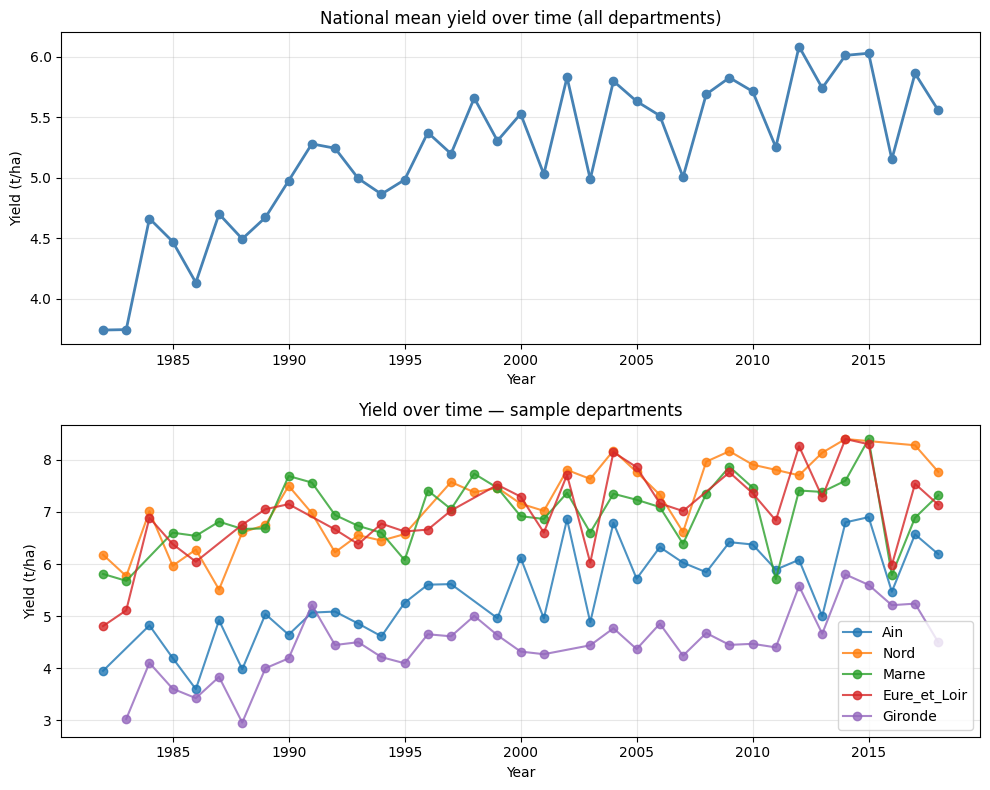

Correlation yield ~ year: 0.351


In [22]:
# 1) Yield trends over time — national and per department
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# National: mean yield by year
national = model_df.groupby("year")["yield"].mean()
axes[0].plot(national.index, national.values, "o-", color="steelblue", linewidth=2)
axes[0].set_title("National mean yield over time (all departments)")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Yield (t/ha)")
axes[0].grid(True, alpha=0.3)

# Sample departments
sample_deps = ["Ain", "Nord", "Marne", "Eure_et_Loir", "Gironde"]
for dep in sample_deps:
    sub = model_df[model_df["nom_dep"] == dep]
    if len(sub) > 0:
        axes[1].plot(sub["year"], sub["yield"], "o-", label=dep, alpha=0.8)
axes[1].set_title("Yield over time — sample departments")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Yield (t/ha)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation yield vs year
print(f"Correlation yield ~ year: {model_df['yield'].corr(model_df['year']):.3f}")

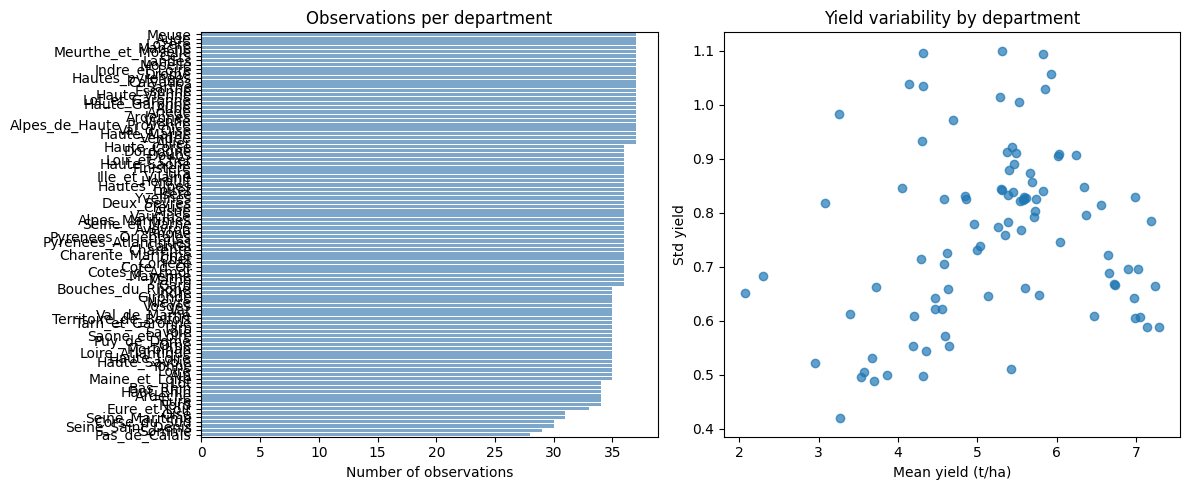

Departments with few observations (< 20): 0
Departments with high variability (std > 1.5): 0


In [23]:
# 2) Yield distribution by department — n_obs and variability
dep_stats = model_df.groupby("nom_dep")["yield"].agg(n_obs="count", mean="mean", std="std").reset_index()
dep_stats = dep_stats.sort_values("n_obs")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].barh(dep_stats["nom_dep"], dep_stats["n_obs"], color="steelblue", alpha=0.7)
axes[0].set_xlabel("Number of observations")
axes[0].set_title("Observations per department")
axes[0].set_ylim(-0.5, len(dep_stats) - 0.5)

axes[1].scatter(dep_stats["mean"], dep_stats["std"], alpha=0.7)
axes[1].set_xlabel("Mean yield (t/ha)")
axes[1].set_ylabel("Std yield")
axes[1].set_title("Yield variability by department")
plt.tight_layout()
plt.show()

print("Departments with few observations (< 20):", (dep_stats["n_obs"] < 20).sum())
print("Departments with high variability (std > 1.5):", (dep_stats["std"] > 1.5).sum())

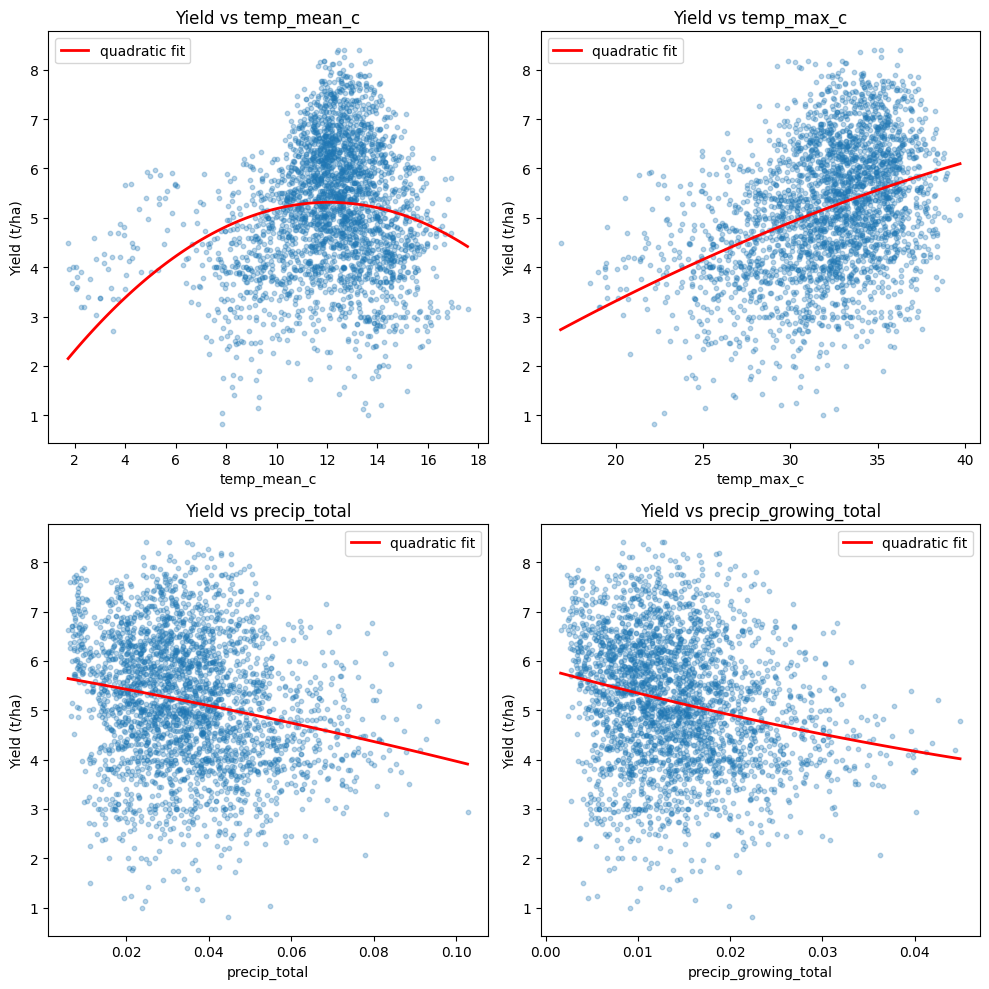

In [24]:
# 3) Climate–yield scatter plots — check for non-linear relationships
# Convert temp from Kelvin to °C for interpretability
df_plot = model_complete.copy()
# Pick 4 key features: temp mean/max, precip mean/max
plot_cols = [c for c in feat_cols if "near_surface_air_temperature" in c and "maximum" not in c][:2]
plot_cols += [c for c in feat_cols if "precipitation" in c][:2]
if len(plot_cols) < 4:
    plot_cols = feat_cols[:4]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, col in zip(axes, plot_cols):
    vals = df_plot[col] - 273.15 if "temperature" in col else df_plot[col]
    ax.scatter(vals, df_plot["yield"], alpha=0.3, s=10)
    ax.set_xlabel(col + (" (°C)" if "temperature" in col else ""))
    ax.set_ylabel("Yield (t/ha)")
    ax.set_title(f"Yield vs {col}")
    valid = vals.notna()
    if valid.sum() > 3:
        z = np.polyfit(vals[valid], df_plot.loc[valid, "yield"], 2)
        p = np.poly1d(z)
        x_line = np.linspace(vals.min(), vals.max(), 100)
        ax.plot(x_line, p(x_line), "r-", linewidth=2, label="quadratic fit")
        ax.legend()
plt.tight_layout()
plt.show()

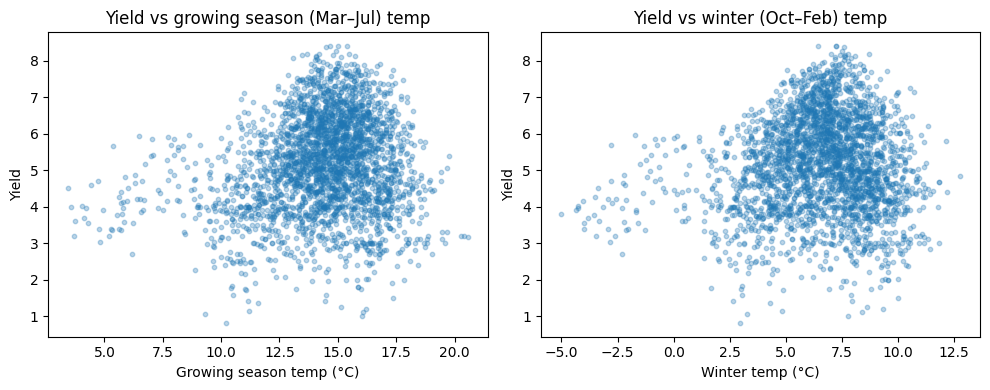

Correlation yield ~ temp_growing: 0.16646707925549203
Correlation yield ~ temp_winter: 0.07362020480747931


In [25]:
# 4) Seasonal patterns — growing (Mar–Jul) vs winter (Oct–Feb)
# Build seasonal aggregates from historical climate
clim_hist = df_climate[df_climate["scenario"] == "historical"].copy()
clim_hist["month"] = pd.to_datetime(clim_hist["time"]).dt.month
clim_hist.loc[clim_hist["metric"] == "precipitation", "value"] = np.maximum(clim_hist.loc[clim_hist["metric"] == "precipitation", "value"], 0)

temp = clim_hist[clim_hist["metric"].str.contains("temperature")]
precip = clim_hist[clim_hist["metric"].str.contains("precip")]

# Growing: Mar–Jul | Winter: Oct (10), Nov (11), Dec (12), Jan (1), Feb (2)
temp_growing = temp[temp["month"].between(3, 7)].groupby(["nom_dep", "year"])["value"].mean().reset_index().rename(columns={"value": "temp_growing"})
temp_winter = temp[temp["month"].isin([1, 2, 10, 11, 12])].groupby(["nom_dep", "year"])["value"].mean().reset_index().rename(columns={"value": "temp_winter"})
precip_growing = precip[precip["month"].between(3, 7)].groupby(["nom_dep", "year"])["value"].sum().reset_index().rename(columns={"value": "precip_growing"})
precip_winter = precip[precip["month"].isin([1, 2, 10, 11, 12])].groupby(["nom_dep", "year"])["value"].sum().reset_index().rename(columns={"value": "precip_winter"})

seasonal = temp_growing.merge(temp_winter, on=["nom_dep", "year"]).merge(precip_growing, on=["nom_dep", "year"]).merge(precip_winter, on=["nom_dep", "year"])
seasonal_model = model_complete[["nom_dep", "year", "yield"]].merge(seasonal, on=["nom_dep", "year"], how="inner")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(seasonal_model["temp_growing"] - 273.15, seasonal_model["yield"], alpha=0.3, s=10)
axes[0].set_xlabel("Growing season temp (°C)")
axes[0].set_ylabel("Yield")
axes[0].set_title("Yield vs growing season (Mar–Jul) temp")

axes[1].scatter(seasonal_model["temp_winter"] - 273.15, seasonal_model["yield"], alpha=0.3, s=10)
axes[1].set_xlabel("Winter temp (°C)")
axes[1].set_ylabel("Yield")
axes[1].set_title("Yield vs winter (Oct–Feb) temp")
plt.tight_layout()
plt.show()

print("Correlation yield ~ temp_growing:", seasonal_model["yield"].corr(seasonal_model["temp_growing"]))
print("Correlation yield ~ temp_winter:", seasonal_model["yield"].corr(seasonal_model["temp_winter"]))

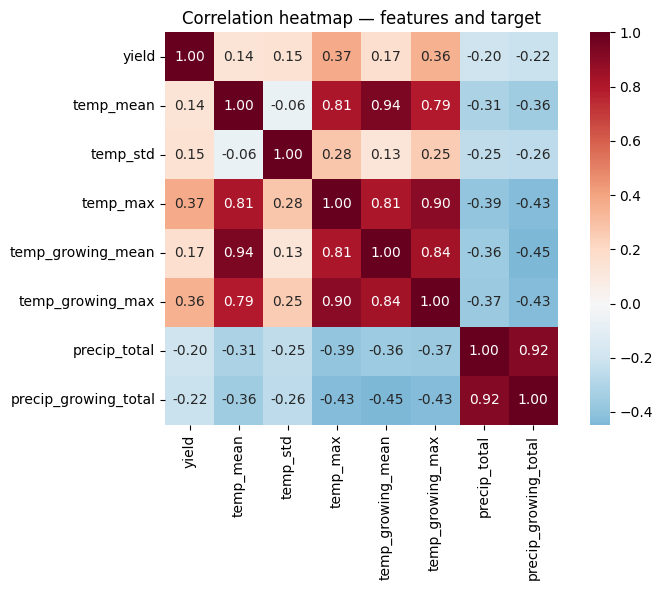

Pairs with |r| > 0.7: [('temp_max', 'temp_mean'), ('temp_growing_mean', 'temp_mean'), ('temp_growing_mean', 'temp_max'), ('temp_growing_max', 'temp_mean'), ('temp_growing_max', 'temp_max'), ('temp_growing_max', 'temp_growing_mean'), ('precip_growing_total', 'precip_total')]


In [26]:
# 5) Correlation heatmap — multicollinearity check
num_cols = ["yield"] + [c for c in model_complete.columns if c in feat_cols]
corr = model_complete[num_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax, square=True)
ax.set_title("Correlation heatmap — features and target")
plt.tight_layout()
plt.show()

# High correlations (potential multicollinearity)
high_corr = [(i, j) for i in corr.columns for j in corr.columns if i < j and abs(corr.loc[i, j]) > 0.7]
print("Pairs with |r| > 0.7:", high_corr)

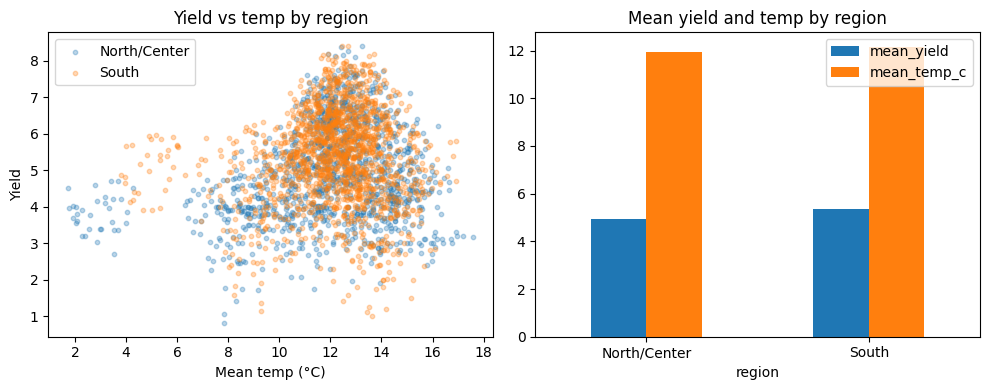

In [27]:
# 6) Geographic patterns — north vs south France
temp_col = [c for c in feat_cols if "temperature" in c and "mean" in c][0] if feat_cols else None
dep_codes = df_climate[df_climate["scenario"] == "historical"][["nom_dep", "code_dep"]].drop_duplicates()
geo_df = model_complete.merge(dep_codes, on="nom_dep", how="left")
geo_df["code_int"] = pd.to_numeric(geo_df["code_dep"], errors="coerce")
geo_df["region"] = np.where(geo_df["code_int"] < 40, "North/Center", "South")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
if temp_col:
    for reg in ["North/Center", "South"]:
        sub = geo_df[geo_df["region"] == reg]
        axes[0].scatter(sub[temp_col] - 273.15, sub["yield"], alpha=0.3, s=10, label=reg)
axes[0].set_xlabel("Mean temp (°C)")
axes[0].set_ylabel("Yield")
axes[0].set_title("Yield vs temp by region")
axes[0].legend()

reg_summary = geo_df.groupby("region").agg(mean_yield=("yield", "mean"), mean_temp_c=(temp_col, lambda x: (x - 273.15).mean())) if temp_col else geo_df.groupby("region")["yield"].mean().to_frame("mean_yield")
reg_summary.plot(kind="bar", ax=axes[1], legend=True)
axes[1].set_title("Mean yield and temp by region")
axes[1].set_xticklabels(reg_summary.index, rotation=0)
plt.tight_layout()
plt.show()

---

### Summary: what we see in the analytical EDA

**Yield trends over time**
- Clear **upward trend** in national mean yield (1982–2018) — correlation with year ~+0.35. Reflects agricultural technology improvements (better varieties, inputs, practices).
- Individual departments follow similar trends with different levels. **Implication**: Consider adding `year` as a feature or detrending yield before modeling climate effects.

**Yield distribution by department**
- Departments vary in **number of observations** (some have gaps) and **variability** (std). Urban/small-production departments (Paris, Hauts-de-Seine) have fewer obs and more noise.
- **Implication**: Filter to departments with sufficient observations (e.g. n ≥ 20) and/or meaningful production for a cleaner model.

**Climate–yield relationships**
- **Temperature**: Positive correlation with yield (warmer → higher yield in this range). Quadratic fit suggests possible non-linearity — yield may peak and decline at very high temps (heat stress).
- **Precipitation**: Negative correlation — more rain associated with lower yield (waterlogging, disease). Non-linear patterns possible.
- **Implication**: Tree-based models (RF, XGBoost) can capture non-linearities; consider polynomial or spline terms for linear models.

**Seasonal patterns**
- **Growing season (Mar–Jul)** temp correlates with yield (main driver).
- **Winter (Oct–Feb)** conditions also matter for winter barley — worth including as features.
- **Implication**: Keep both growing-season and winter aggregates in feature engineering.

**Multicollinearity**
- `temp_mean`, `temp_growing_mean`, `temp_max`, `temp_growing_max` are **highly correlated** (r > 0.7).
- **Implication**: Use regularization (Ridge/Lasso) or tree models; avoid redundant temp features; consider PCA or selecting one temp metric per type.

**Geographic patterns**
- North/Center vs South show different mean yields and temperatures — **regional structure** exists.
- **Implication**: Consider department or region as a feature (target encoding) to capture unobserved geographic effects.